In [1]:
#For numerics
import numpy as np

#For loading and saving data
import pandas as pd

#For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

#For TeX plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

#For colorblind plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())

#
import itertools

#For setting root path and accessing files
import sys
import os
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root not in sys.path:
    sys.path.append(root)
os.chdir('..') 
import h5py

#for caching cross-section values
from functools import lru_cache

from lepton_nucleus_collisions.utils.process import (process_run_card,
                                                     process_dcrossx,
                                                     read_dcrossx,
                                                     open_dcrossx,
                                                     lepton_idx
                                                    )
from lepton_nucleus_collisions.utils.lab_frame import lab_frame_distributions
from phys.constants import me, mm, mt, hc2_fbGeV2

In [2]:
colliders = ['E137', 'EIC_Gold', 'MuSIC', 'MuCol']
collider_colors = [colors[1], colors[0], colors[2], colors[3]]
collider_TeX = ['$\\textrm{E137}$','$\\textrm{EIC}$','$\\textrm{MuSIC}$','$\\textrm{MuBD}$']

color_dict = dict(zip(colliders, collider_colors))
TeX_dict = dict(zip(colliders, collider_TeX))
run_cards = [f'{collider}.txt' for collider in colliders]

In [3]:
@lru_cache
def dcrossx_eta_gamma(collider, params):
    
    v_nuc, E, masses = process_run_card(f'{collider}.txt', ['v_nuc', 'E', 'masses'])
    f = np.sqrt((1 + v_nuc)/(1 - v_nuc))
    
    shape = (len(masses), 1000)
    
    eta = np.empty(shape)
    gamma = np.empty(shape)
    dcrossx_deta = np.empty(shape)
    dcrossx_dgamma = np.empty(shape)

    for idx, m in enumerate(masses):
        e = np.linspace(-30, 30, 1000)
        eta[idx] = e
        g_max = max(1, E/(f*m)) + f * m/(4*E)
        g = np.logspace(1e-3, np.log10(1.2*g_max), 1000)
        gamma[idx] = g
        dcrossx_dgamma[idx], dcrossx_deta[idx] = lab_frame_distributions(collider, params + (m,), g, e)
        
    return gamma, eta, dcrossx_dgamma, dcrossx_deta
    
@lru_cache(maxsize=None)
def crossx(collider, params, units = 'pb'):
    file_name = f'lepton_nucleus_collisions/data/{collider}.h5'
    masses = process_run_card(f'{collider}.txt', 'masses')
    sig = np.array([open_dcrossx(file_name, params + (m,), 'SIG') for m in masses])
    if units == 'fb':
        return hc2_fbGeV2*sig
    if units == 'pb':
        return (hc2_fbGeV2/1000)*sig
    return sig
    
@lru_cache
def crossx_lab(collider, params, eta_min = -np.inf, eta_max = np.inf, units = 'pb'):
    if units == 'pb':
        return (hc2_fbGeV2/1000)*crossx_lab(collider, params, eta_min, eta_max, units = 'GeV')
    if units == 'fb':
        return hc2_fbGeV2*crossx_lab(collider, params, eta_min, eta_max, units = 'GeV')
    _, eta, _, dcrossx_deta = dcrossx_eta_gamma(collider, params)
    return np.trapz(dcrossx_deta*(eta > eta_min)*(eta < eta_max), x = eta)

In [4]:
mt = 1.777
Lam = 1000
scalar_to_ALP = (mt/Lam)**2

masses = np.array(process_run_card('EIC_Gold.txt', 'masses'))

EIC_crossx_tot = scalar_to_ALP*crossx('EIC_Gold', ('tau', 'scalar', 1.0, 'exact', False), units = 'fb')

EIC_crossx = scalar_to_ALP*crossx_lab('EIC_Gold', ('tau', 'scalar', 1.0, 'exact', False),
                                      eta_min = -3.5, eta_max = 3.5, units = 'fb')

MuSIC_crossx_tot = scalar_to_ALP*crossx('MuSIC', ('tau', 'scalar', 1.0, 'exact', False), units = 'fb')

MuSIC_crossx = scalar_to_ALP*crossx_lab('MuSIC', ('tau', 'scalar', 1.0, 'exact', False),
                                        eta_min = -6, eta_max = 6, units = 'fb')


MuBeD_crossx_tot = scalar_to_ALP*crossx('MuCol', ('tau', 'scalar', 1.0, 'exact', False), units = 'fb')

MuBeD_crossx = scalar_to_ALP*crossx_lab('MuCol', ('tau', 'scalar', 1.0, 'exact', False), units = 'fb')

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_65758/2017653804.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(dcrossx_deta*(eta > eta_min)*(eta < eta_max), x = eta)


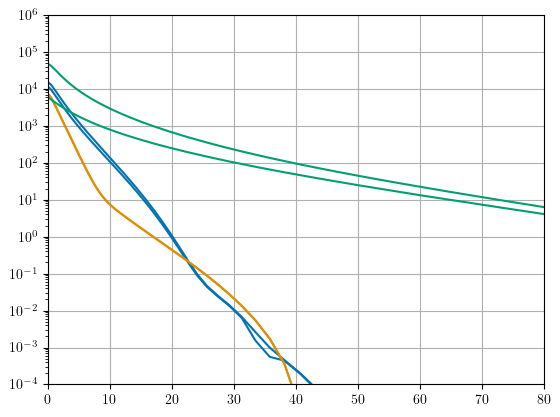

In [470]:

plt.plot(masses, EIC_crossx_tot, color = colors[0])
plt.plot(masses, EIC_crossx, color = colors[0])
plt.plot(masses, MuBeD_crossx_tot, color = colors[1])
plt.plot(masses, MuBeD_crossx, color = colors[1])
plt.plot(masses, MuSIC_crossx_tot, color = colors[2])
plt.plot(masses, MuSIC_crossx, color = colors[2])
plt.yscale('log')
plt.xlim(0, 80)
plt.ylim(1e-4, 1e6)
plt.grid()

In [6]:
from phys.utils import poisson_confidence_interval

In [7]:
# e^- ta^+ ta^-

# mis-ID e^- as e^+ (10^-3), identify ta^+ (10^-2), ta^- doesn't decay to e^- (1-0.18)
# mis-ID e^- as e^+ (10^-3), identify ta^- (10^-2)
#lose e^- (10^-2), ta^+ decays to e^+ (0.18), identify ta^- (10^-2)

In [8]:
tau_ID = 1e-2
r_mis_ID = 1e-3
r_loss = 1e-2
r_te = 0.18
eff_bg =  r_mis_ID * tau_ID * (1 - r_te) + r_mis_ID * tau_ID + r_loss * tau_ID * r_te

In [9]:
from phys.formulae.ALP_EFT import ALP_fermion_decay_rate, ALP_decay_rate

In [10]:
def EIC_bg_efficiency(tau_ID = 1e-1,
                      electron_positron_mis_ID = 1e-3,
                      electron_loss_rate = 1e-3,
                      tau_nu_e_decay_rate = 0.18):
    return tau_ID * (electron_positron_mis_ID * (1 + 1 - r_te) + electron_loss_rate * r_te)

def EIC_signal_efficiency(tau_ID = 1e-1, tau_nu_e_decay_rate = 0.18, C = [[0, 0, 1],[0,0,0],[1,0,0]]):
    B_te = ALP_fermion_decay_rate(masses, mt, me, Cij = C[0][2])/ALP_decay_rate(masses, Cff = C) #a -> e^+ ta^-
    B_tt = ALP_fermion_decay_rate(masses, mt, mt, Cij = C[2][2])/ALP_decay_rate(masses, Cff = C) #a -> ta^+ ta^-
    return 2*tau_ID * (1 - tau_nu_e_decay_rate) * (B_te + tau_nu_e_decay_rate *B_tt)
    
def MuBeD_efficiency(tau_ID = 1e-1):
    return tau_ID**2

def MuSIC_efficiency(tau_ID = 1e-1):
    return tau_ID**2

In [189]:
A = 183
def EIC_limit(crossx, crossx_bg, luminosity = 100/A, C = [[0, 0, 1],[0,0,0],[1,0,0]]):
    n_bg = EIC_bg_efficiency() * crossx_bg * luminosity
    n_max = 2*np.sqrt(n_bg)
    n_sig = EIC_signal_efficiency(C = C) * crossx * luminosity 
    
    return np.sqrt(n_max/n_sig)

A = 207
def MuSIC_limit(crossx, luminosity = 100/A, C = [[0, 0, 0],[0,0,1],[0,1,0]]):
    n_max = 3.5
    B_tm = ALP_fermion_decay_rate(masses, mt, mm, Cij = C[1][2])/ALP_decay_rate(masses, Cff = C) #a -> mu^+ ta^-
    n_sig = MuSIC_efficiency() * crossx * luminosity  * 2 * B_tm
    
    return np.sqrt(n_max/n_sig)

def MuBeD_limit(crossx, luminosity = 1e18 * 6.592e-17, C = [[0, 0, 0],[0,0,1],[0,1,0]]):
    n_max = 3.5
    B_tm = ALP_fermion_decay_rate(masses, mt, mm, Cij = C[1][2])/ALP_decay_rate(masses, Cff = C) #a -> mu^+ ta^-
    n_sig = MuBeD_efficiency() * crossx * luminosity * 2 * B_tm
    
    return np.sqrt(n_max/n_sig)

In [36]:
from dipole_form_factors.formulae.dipole_moments import da_2sig_e_Cs, da_2sig_e_Rb, da_2sig_mu, a_ij

In [230]:
def str_to_tuple(str_tuple):
    return tuple([int(i) for i in str_tuple[1:-1].split(',')])

def extract_f_dict(file):
    df = pd.read_csv(file, index_col = 0)
    
    df.columns = [str_to_tuple(col) for col in df.columns]
    
    f_dict = {'mass': df.index.to_numpy(dtype = np.float64)}
    for col in df.columns:
        f_dict[col] = df[col].to_numpy(dtype = np.complex128)
    return f_dict

func_names = ['f2_plus', 'f2_minus', 'f3_plus', 'f3_minus']
functions = []
for func_name in func_names:
    file = root + f'/dipole_form_factors/data/{func_name}.csv'
    functions.append(extract_f_dict(file))
f2p, f2m, f3p, f3m = functions
m_LFV = f2p['mass']

def g_2_explanation(da2, i, nsig = 2, ij = (1, 1), C = [[1]*3]*3, TH = [[0]*3]*3, mode = None, Lam = 1000):
    if not hasattr(TH, '__iter__'):
        TH = TH*np.ones((3, 3))

    sig = (da2[1]-da2[0])/4
    anomaly = (da2[1]+da2[0])/2
    
    da = 0
    for j in range(3):
        da += a_ij(f2p, f2m, i, j, g = C, th = TH, mode = mode, ALP = True, Lam = 1000)/C[ij[0]][ij[1]]**2

    return np.sqrt((anomaly - nsig*sig)/da), np.sqrt((anomaly + nsig*sig)/da)

def read_LFV_limits(file, lepton_tuple, confidence = 0.95):
    df = pd.read_csv(file, index_col = 0)
    m = df.index.to_numpy(dtype = np.float64)
    limit = df[str(lepton_tuple)].to_numpy(dtype = np.float64)

    # By default, limit is 90% confidence. Limit is proportional to
    # (90% upper bound on decay rate)^{1/4}. For a Poisson counting
    # experiment with zero observed events, the upper bound on the
    # mean is proportional to -log(1 - confidence). 
    # In practice, this will barely change anything. For example.
    # (log(1 - 0.95)/log(1 - 0.9))^(1/4) = 1.068
    
    z_score_conf = -np.log(1-confidence)
    z_score_90 = -np.log(0.1)
    limit = (z_score_conf/z_score_90)**(1/4) * limit
    
    return m, limit

def plot_dipole_limits(ij, ax = None, color = colors[8]):
    if not ax:
        ax = plt.gca()
    
    li, lj = ij

    #only one limit on off-diagonal coupling
    process = (li, li, lj)

    m, PC_limit = read_LFV_limits('dipole_form_factors/data/mdm_PC_ALP_limits.csv', process)
    m, chi_limit = read_LFV_limits('dipole_form_factors/data/mdm_chiral_ALP_limits.csv', process)
    
    absolute_limit = np.minimum(PC_limit,chi_limit)
    
    ax.fill_between(m, absolute_limit, 1e3, color = color, alpha = 0.1)
    ax.plot(m, chi_limit, 1e3, color = 'black', linewidth = 0.5, dashes = (4, 8))
    ax.plot(m, PC_limit, 1e3, color = 'black', linewidth = 0.5)
    ax.plot(m, absolute_limit, 1e3, color = 'black', linewidth = 0.5)

    return ax

In [231]:
from lfv_higgs_decays.formulae.signal_branching_fractions import (ta_to_Cij,
                                                                  Cij_to_ta,
                                                                  BR_H_X_to_Cah,
                                                                  H_to_OSSF0_signal_efficiency,
                                                                  BR_aa_OSSF0,
                                                                  f_detect,
                                                                  BR_aa_jets,
                                                                  CMS_Cah_limits,
                                                                  ATLAS_Cah_limits,
                                                                  MATH_Cah_limits)

#For finding contour boundaries
from skimage import measure

def find_contours(x, y, Z, Z_val = 1):
    contours = measure.find_contours(Z, Z_val)

    boundary_pts = []
    for cont in contours:
        i, j = cont.T[0], cont.T[1]  # Extract row/col indices
        x_coords = np.interp(i, np.arange(len(x)), x)  # Map cols to x
        y_coords = np.interp(j, np.arange(len(y)), y)  # Map rows to y
        boundary_pts.append(np.column_stack((x_coords, y_coords)).T)

    return boundary_pts

def plot_Higgs_decay_limits(Cah,
                            which = 'Cah',
                            ax = None,
                            ij = (0, 2),
                            Cll = [[1]*3]*3, 
                            CMS_color = 'grey',
                            ATLAS_color = 'grey',
                            projections = False,
                            combine = False,
                            lifetime_lines = False):
    if not ax:
        ax = plt.gca()
    plot_masses = np.linspace(0, 62.5, 400)
    plot_Cll = np.logspace(-10, 2, 400)
    plot_ta = Cij_to_ta(plot_Cll, plot_masses, Cll = Cll, idx = ij)

    if lifetime_lines:
        for exp in range(-12, 7, 3):
            ta = 10.0**exp
            Cij_from_ta = ta_to_Cij(ta, plot_masses, Cll = Cll, idx = ij)
            ax.plot(plot_masses, Cij_from_ta, color = 'black', linewidth = 0.25)
            
            plt.text(53.5, 1.35*ta_to_Cij(ta, 62.5, Cll = Cll, idx = ij), f'$c\\tau_a = 10^{{{exp}}}~{{\\rm m}}$', fontsize = 10)

    #projections
    if projections:
        #######################
        #         CMS         #
        #######################
    
        Cah_CMS_proj = CMS_Cah_limits(plot_masses, plot_ta, which = which, Cll = Cll, L = 3000)
    
        #######################
        #        ATLAS        #
        #######################
    
        Cah_ATLAS_proj = ATLAS_Cah_limits(plot_masses, plot_ta, which = which, Cll = Cll, L = 3000)
        
        #######################
        #       MATHUSLA      #
        #######################
        
        Cah_MATH_proj = MATH_Cah_limits(plot_masses, plot_ta, which = which, Cll = Cll, L = 3000)
        
        Cah_proj = np.nanmin([Cah_CMS_proj, Cah_ATLAS_proj, Cah_MATH_proj], axis = 0)
    
        contours = find_contours(plot_masses, plot_Cll, Cah_proj, Cah)
        for contour in contours:
            ax.plot(*contour, color = 'black', dashes = (8, 8), linewidth = 0.5)
            ax.fill(*contour, color = 'grey' , alpha = 0.075)

    ############# Constraints ##############

    #######################
    #         CMS         #
    #######################
    
    Cah_CMS = CMS_Cah_limits(plot_masses, plot_ta, which = which, Cll = Cll, L = 137)
    
    #######################
    #        ATLAS        #
    #######################

    Cah_ATLAS = ATLAS_Cah_limits(plot_masses, plot_ta, which = which, Cll = Cll, L = 36)

    if combine:
        Cah_total = np.nanmin([Cah_CMS,Cah_ATLAS], axis = 0)
        contours = find_contours(plot_masses, plot_Cll, Cah_total, Cah)
        for contour in contours:
            ax.fill(*contour, color = 'grey', edgecolor = 'black', alpha = 0.6)        
    else:
        #CMS
        contours = find_contours(plot_masses, plot_Cll, Cah_CMS, Cah)
        for contour in contours:
            ax.fill(*contour, color = CMS_color, edgecolor = 'black', alpha = 0.6)
    
        #ATLAS
        contours = find_contours(plot_masses, plot_Cll, Cah_ATLAS, Cah)
        for contour in contours:
            ax.fill(*contour, color = ATLAS_color, edgecolor = 'black', alpha = 0.6)

    ax.tick_params(which = 'both', direction = 'in', labelsize = 12)
    ax.set_xlim(1.77, 62.5)
    ax.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 14)
    ax.set_ylim(1e-9, 1e2)
    ax.set_yscale('log')
    ax.set_ylabel('$C_{\\tau \\ell}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)
    return ax

/Volumes/T7/Research/Thesis/phys/formulae/ALP_EFT.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  th[i,j] = np.arctan((mf[i]+mf[j])/(mf[i]-mf[j]) / np.tan(TH[i][j]))
/Volumes/T7/Research/Thesis/dipole_form_factors/formulae/dipole_moments.py:160: RuntimeWarning: invalid value encountered in sqrt
  exact-= (x+2)/3 * np.sqrt((x-4)*x)*np.log((np.sqrt(x)+np.sqrt(x-4))/2)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_65758/3188254154.py:33: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((anomaly - nsig*sig)/da), np.sqrt((anomaly + nsig*sig)/da)


(0.1, 100.0)

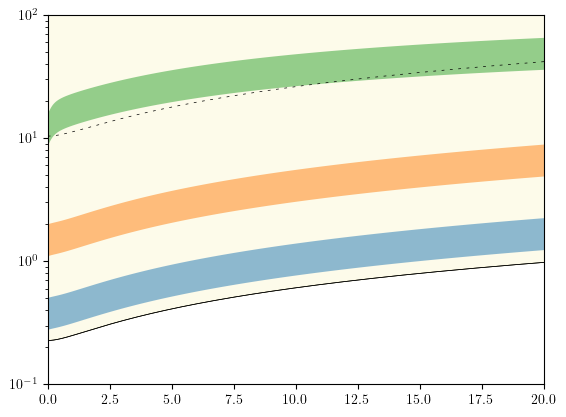

In [232]:
Cij = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]

plot_dipole_limits((0, 2))

low, high = g_2_explanation(da_2sig_e_Cs, 0, ij = (0, 2), mode = 'PC')
plt.fill_between(m_LFV, low, high, alpha = 0.5)

low, high = g_2_explanation(da_2sig_e_Cs, 0, ij = (0, 2), TH = 0.24*np.pi)
plt.fill_between(m_LFV, low, high, alpha = 0.5)

low, high = g_2_explanation(da_2sig_e_Cs, 0, ij = (0, 2), mode = 'chiral')
plt.fill_between(m_LFV, low, high, alpha = 0.5)
plt.xlim(0, 20)
plt.yscale('log')
plt.ylim(1e-1, 1e2)

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_65758/3188254154.py:33: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((anomaly - nsig*sig)/da), np.sqrt((anomaly + nsig*sig)/da)


(0.1, 100.0)

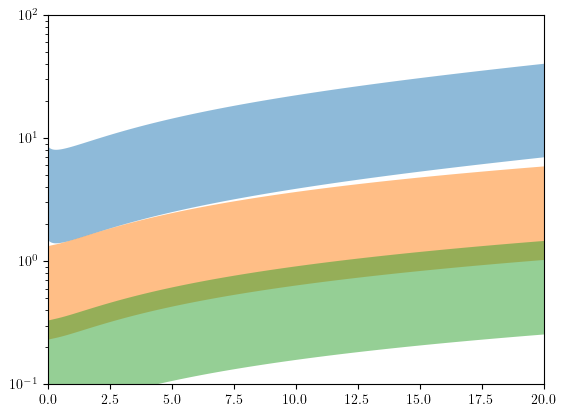

In [233]:
Cij = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]
low, high = g_2_explanation(da_2sig_e_Rb, 0, ij = (0, 2),TH = 0.2504*np.pi)
plt.fill_between(m_LFV, low, high, alpha = 0.5)

low, high = g_2_explanation(da_2sig_e_Rb, 0, ij = (0, 2), TH = 0.26*np.pi)
plt.fill_between(m_LFV, low, high, alpha = 0.5)

low, high = g_2_explanation(da_2sig_e_Rb, 0, ij = (0, 2), TH = np.pi/2)
plt.fill_between(m_LFV, low, high, alpha = 0.5)
plt.xlim(0, 20)
plt.yscale('log')
plt.ylim(1e-1, 1e2)

(0.1, 100.0)

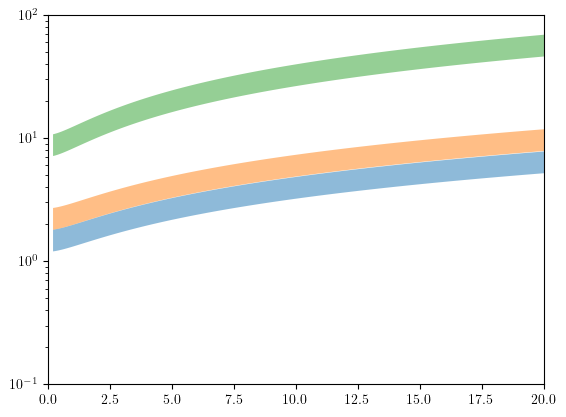

In [242]:
C = [[0, 0, 0],
     [0, 0, 1],
     [0, 1, 0]]

low, high = g_2_explanation(da_2sig_mu, 1, ij = (1, 2), TH = np.pi/2, C = C)
plt.fill_between(m_LFV, low, high, alpha = 0.5)

low, high = g_2_explanation(da_2sig_mu, 1, ij = (1, 2), TH = np.pi/3, C = C)
plt.fill_between(m_LFV, low, high, alpha = 0.5)

low, high = g_2_explanation(da_2sig_mu, 1, ij = (1, 2), TH = 0.27*np.pi, C = C)
plt.fill_between(m_LFV, low, high, alpha = 0.5)
plt.xlim(0, 20)
plt.yscale('log')
plt.ylim(1e-1, 1e2)

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_65758/3237195978.py:8: RuntimeWarning: invalid value encountered in divide
  B_te = ALP_fermion_decay_rate(masses, mt, me, Cij = C[0][2])/ALP_decay_rate(masses, Cff = C) #a -> e^+ ta^-
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_65758/3237195978.py:9: RuntimeWarning: invalid value encountered in divide
  B_tt = ALP_fermion_decay_rate(masses, mt, mt, Cij = C[2][2])/ALP_decay_rate(masses, Cff = C) #a -> ta^+ ta^-
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_65758/15392788.py:7: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(n_max/n_sig)


(0.0, 62.5)

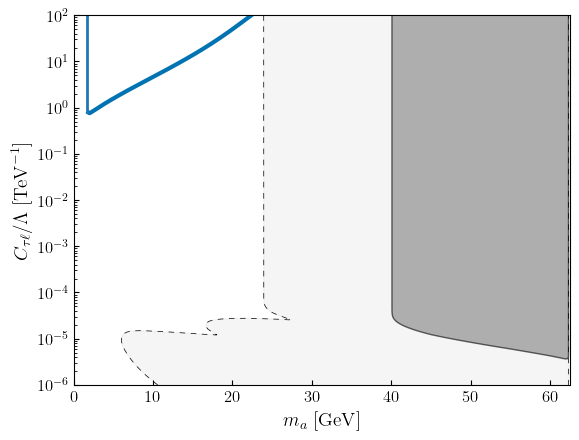

In [427]:
#plot_dipole_limits((0, 2))

Cll = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]
plot_Higgs_decay_limits(1, ij = (0, 2), which = 'Cahp', Cll = Cll, combine = True, projections = True)

eic_limit = EIC_limit(EIC_crossx, 2.5e4*1000)
#plt.fill_between(masses, eic_limit, 100, color = colors[0], edgecolor = 'black', alpha = 0.5)
plt.plot(masses, eic_limit, 100, color = colors[0], linewidth = 3)
plt.axvline(1.63, 0.737, 1, linewidth = 2)

plt.yscale('log')
plt.ylim(1e-6, 1e2)
plt.xlim(0, 62.5)

/Volumes/T7/Research/Thesis/phys/formulae/ALP_EFT.py:47: RuntimeWarning: invalid value encountered in power
  rate*= (ma**2 - (mi-mj)**2)**(3/2)
/Volumes/T7/Research/Thesis/phys/formulae/ALP_EFT.py:48: RuntimeWarning: invalid value encountered in sqrt
  rate*= (ma**2 - (mi+mj)**2)**(1/2)
/Volumes/T7/Research/Thesis/phys/formulae/ALP_EFT.py:28: RuntimeWarning: invalid value encountered in arcsin
  t_gt_1 = np.arcsin(1/np.sqrt(t))
/Volumes/T7/Research/Thesis/phys/formulae/ALP_EFT.py:30: RuntimeWarning: invalid value encountered in sqrt
  t_lt_1 = np.pi/2 + 1j/2*np.log((1+np.sqrt(1-t))/(1-np.sqrt(1-t)))
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_65758/3237195978.py:8: RuntimeWarning: invalid value encountered in divide
  B_te = ALP_fermion_decay_rate(masses, mt, me, Cij = C[0][2])/ALP_decay_rate(masses, Cff = C) #a -> e^+ ta^-
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_65758/3237195978.py:9: RuntimeWarning: invalid value encountered in divide
  B_tt = ALP_f

(0.0, 20.0)

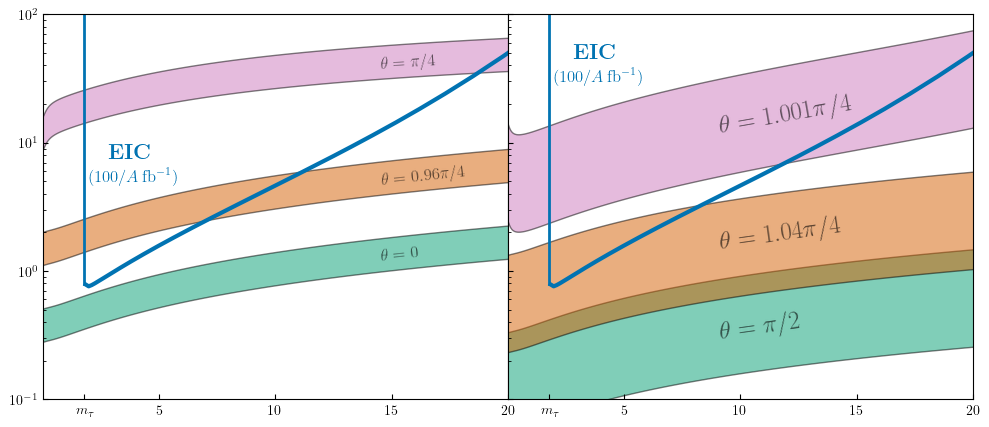

In [453]:
Cij = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]

fig = plt.figure(figsize = (12, 5))
gs = GridSpec(1, 2, wspace = 0)

ax1 = fig.add_subplot(gs[0]) 

eic_limit = EIC_limit(EIC_crossx, 2.5e4*1000)
ax1.plot(masses, eic_limit, color = colors[0], linewidth = 3)

low, high = g_2_explanation(da_2sig_e_Cs, 0, ij = (0, 2), mode = 'PC')
ax1.fill_between(m_LFV, low, high, alpha = 0.5, color = colors[2], edgecolor = 'black')

low, high = g_2_explanation(da_2sig_e_Cs, 0, ij = (0, 2), TH = 0.24*np.pi)
ax1.fill_between(m_LFV, low, high, alpha = 0.5, color = colors[3], edgecolor = 'black')

low, high = g_2_explanation(da_2sig_e_Cs, 0, ij = (0, 2), mode = 'chiral')
ax1.fill_between(m_LFV, low, high, alpha = 0.5, color = colors[4], edgecolor = 'black')

ax1.axvline(1.78, 0.3, 1e2, color = colors[0], linewidth = 2)

ax1.text(14.5, 38, '$\\theta = \\pi/4$', rotation = 4, fontsize = 12, alpha = 0.6)
ax1.text(14.5, 4.7, '$\\theta = 0.96\\pi/4$', rotation = 6, fontsize = 12, alpha = 0.6)
ax1.text(14.5, 1.2, '$\\theta = 0$', rotation = 6, fontsize = 12, alpha = 0.6)

ax1.text(2.8, 7.6, '${\\bf EIC}$', fontsize = 16, color = colors[0])
ax1.text(2., 5, '$(100/A~{\\rm fb}^{-1})$', fontsize = 12, color = colors[0])

ax1.set_xticks([1.777] + [5*i for i in range(1, 5)], ['$m_\\tau$'] + [f'${5*i}$' for i in range(1, 5)])
ax1.tick_params(which = 'both', direction = 'in')

ax1.set_yscale('log')
ax1.set_ylim(1e-1, 1e2)
ax1.set_xlim(0, 20)


ax2 = fig.add_subplot(gs[1])

eic_limit = EIC_limit(EIC_crossx, 2.5e4*1000)
ax2.plot(masses, eic_limit, color = colors[0], linewidth = 3)

low, high = g_2_explanation(da_2sig_e_Rb, 0, ij = (0, 2), TH = np.pi/2)
ax2.fill_between(m_LFV, low, high, alpha = 0.5, color = colors[2], edgecolor = 'black')

low, high = g_2_explanation(da_2sig_e_Rb, 0, ij = (0, 2), TH = 1.04*np.pi/4)
ax2.fill_between(m_LFV, low, high, alpha = 0.5, color = colors[3], edgecolor = 'black')

low, high = g_2_explanation(da_2sig_e_Rb, 0, ij = (0, 2), TH = 1.001*np.pi/4)
ax2.fill_between(m_LFV, low, high, alpha = 0.5, color = colors[4], edgecolor = 'black')

ax2.axvline(1.78, 0.3, 1e2, color = colors[0], linewidth = 2)

ax2.text(9, 12, '$\\theta = 1.001\\pi/4$', rotation = 10, fontsize = 18, alpha = 0.6)
ax2.text(9, 1.5, '$\\theta = 1.04\\pi/4$', rotation = 8, fontsize = 18, alpha = 0.6)
ax2.text(9, 0.3, '$\\theta = \\pi/2$', rotation = 8, fontsize = 18, alpha = 0.6)

ax2.text(2.8, 45.6, '${\\bf EIC}$', fontsize = 16, color = colors[0])
ax2.text(2., 30, '$(100/A~{\\rm fb}^{-1})$', fontsize = 12, color = colors[0])

ax2.set_xticks([1.777] + [5*i for i in range(1, 5)], ['$m_\\tau$'] + [f'${5*i}$' for i in range(1, 5)])
ax2.tick_params(which = 'both', direction = 'in', labelleft = False)

ax2.set_yscale('log')
ax2.set_ylim(1e-1, 1e2)
ax2.set_xlim(0, 20)



/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_65758/15392788.py:19: RuntimeWarning: invalid value encountered in divide
  B_tm = ALP_fermion_decay_rate(masses, mt, mm, Cij = C[1][2])/ALP_decay_rate(masses, Cff = C) #a -> mu^+ ta^-
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_65758/15392788.py:22: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(n_max/n_sig)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_65758/15392788.py:12: RuntimeWarning: invalid value encountered in divide
  B_tm = ALP_fermion_decay_rate(masses, mt, mm, Cij = C[1][2])/ALP_decay_rate(masses, Cff = C) #a -> mu^+ ta^-


(0.0, 62.5)

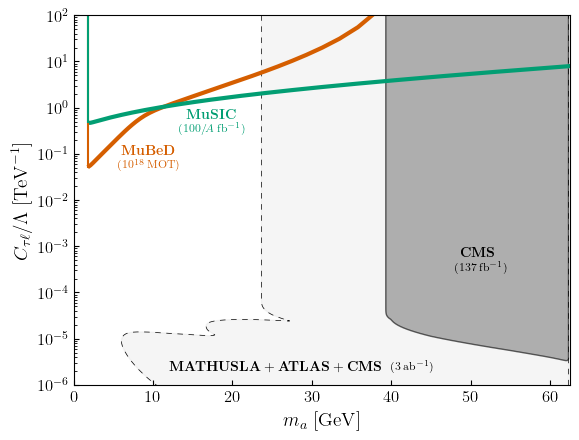

In [419]:
#plot_dipole_limits((1, 2))

Cll = [[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]]
plot_Higgs_decay_limits(1, ij = (1, 2), Cll = Cll, which = 'Cahp', combine = True, projections = True)

plt.yscale('log')
plt.ylim(1e-4, 1e2)
plt.xlim(0, 20)

mubed_limit = MuBeD_limit(MuBeD_crossx)
plt.plot(masses, mubed_limit, color = colors[3], linewidth = 3)

music_limit = MuSIC_limit(MuSIC_crossx)
plt.plot(masses, music_limit, color = colors[2], linewidth = 3)

plt.text(14.2, 0.6, '${\\bf MuSIC}$', color = colors[2], fontsize = 10)
plt.text(13.3, 0.3, '$(100/A~{\\rm fb}^{-1})$', color = colors[2], fontsize = 8)

plt.text(6, 1e-1, '${\\bf MuBeD}$', color = colors[3], fontsize = 10)
plt.text(5.6, 5e-2, '$(10^{18}~{\\rm MOT})$', color = colors[3], fontsize = 8)

plt.text(48.7, 6e-4, '${\\bf CMS}$', fontsize = 10)
plt.text(48, 3e-4, '$(137~{\\rm fb}^{-1})$', fontsize = 8)

plt.text(12, 2e-6, '${\\bf MATHUSLA + ATLAS + CMS}$', fontsize = 10)
plt.text(40, 2.1e-6, '${(3~{\\rm ab}^{-1})}$', fontsize = 8)


plt.axvline(1.777, 0.59, 1, color = colors[3])
plt.axvline(1.777, 0.71, 1, color = colors[2])

plt.yscale('log')
plt.ylim(1e-6, 1e2)
plt.xlim(0, 62.5)
#plt.xscale('log')

0.1838976440716438
0.41795241576990727


/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_65758/15392788.py:19: RuntimeWarning: invalid value encountered in divide
  B_tm = ALP_fermion_decay_rate(masses, mt, mm, Cij = C[1][2])/ALP_decay_rate(masses, Cff = C) #a -> mu^+ ta^-
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_65758/15392788.py:22: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(n_max/n_sig)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_65758/15392788.py:12: RuntimeWarning: invalid value encountered in divide
  B_tm = ALP_fermion_decay_rate(masses, mt, mm, Cij = C[1][2])/ALP_decay_rate(masses, Cff = C) #a -> mu^+ ta^-


(1.0, 200)

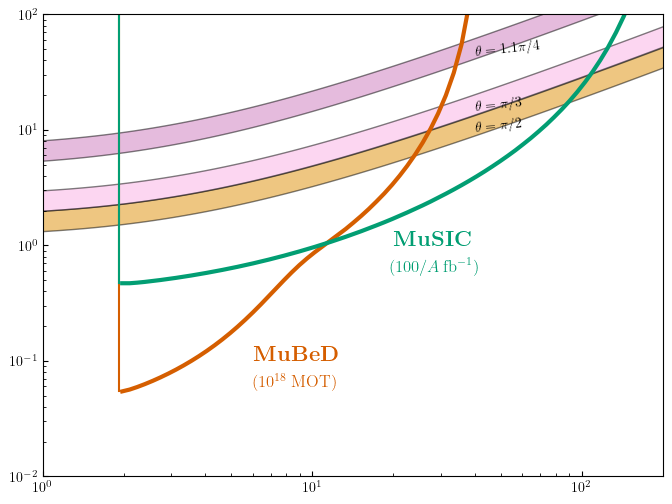

In [468]:
fig = plt.figure(figsize = (8, 6))
Cll = [[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]]

y_min = 1e-2
y_max = 1e2

mubed_limit = MuBeD_limit(MuBeD_crossx, C = Cll)
plt.plot(masses, mubed_limit, color = colors[3], linewidth = 3)

y_val = mubed_limit[np.logical_not(np.isnan(mubed_limit))][0]
frac = (np.log(y_val) - np.log(y_min))/(np.log(y_max) - np.log(y_min))
plt.axvline(1.91, frac, 1, color = colors[3])
print(frac)
music_limit = MuSIC_limit(MuSIC_crossx, C = Cll)
plt.plot(masses, music_limit, color = colors[2], linewidth = 3)

y_val = music_limit[np.logical_not(np.isnan(music_limit))][0]
frac = (np.log(y_val) - np.log(y_min))/(np.log(y_max) - np.log(y_min))
print(frac)
plt.axvline(1.91, frac, 1, color = colors[2])

low, high = g_2_explanation(da_2sig_mu, 1, ij = (1, 2), C = Cll, TH = np.pi/2)
plt.fill_between(m_LFV, low, high, alpha = 0.5, color = colors[1], edgecolor = 'black')

low, high = g_2_explanation(da_2sig_mu, 1, ij = (1, 2), C = Cll, TH = np.pi/3)
plt.fill_between(m_LFV, low, high, alpha = 0.5, color = colors[6], edgecolor = 'black')

low, high = g_2_explanation(da_2sig_mu, 1, ij = (1, 2), C = Cll, TH = 1.1*np.pi/4)
plt.fill_between(m_LFV, low, high, alpha = 0.5, color = colors[4], edgecolor = 'black')

plt.text(20, 1, '${\\bf MuSIC}$', color = colors[2], fontsize = 16)
plt.text(19.5, 0.6, '$(100/A~{\\rm fb}^{-1})$', color = colors[2], fontsize = 12)

plt.text(6, 1e-1, '${\\bf MuBeD}$', color = colors[3], fontsize = 16)
plt.text(6, 6e-2, '$(10^{18}~{\\rm MOT})$', color = colors[3], fontsize = 12)

plt.text(40, 44, '$\\theta = 1.1\\pi/4$', rotation = 6)
plt.text(40, 14.5, '$\\theta = \\pi/3$', rotation = 6)
plt.text(40, 9.5, '$\\theta = \\pi/2$', rotation = 6)

plt.tick_params(which = 'both', direction = 'in')

plt.yscale('log')
plt.xscale('log')
plt.ylim(y_min, y_max)
plt.xlim(1e0, 200)